## Exercise 3

Group: 2216

We chose to skip the creation of new data and used the data generated during class.

In [54]:
#Import necessary packages

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

from tensorflow.keras import regularizers, initializers
import tensorflow.random as tf_r

tf_r.set_seed(12345)
np.random.seed(12345)
input_shape = (60, 1)
n_class     = 3

In [46]:
#Defining functions

def create_model(NCONV = 1,NF = 5,reg_type = 1, reg_lambda1 = 0.5, reg_lambda2 = 0.5):

    ## from keras import regularizers, initializers
    if reg_type == 1:
        reg = tf.keras.regularizers.l1(reg_lambda1)
    
    elif reg_type == 2:
        reg = tf.keras.regularizers.l2(reg_lambda2) ## raised to 0.2
        
    elif reg_type == 3:
        reg = tf.keras.regularizers.l1_l2(reg_lambda1, reg_lambda2)
    
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                            seed=None)
    
    # challenge: at most 600 tunable parameters
    model = Sequential()
    # 
    if NCONV==1:
        # -----2-----
        model.add(Conv1D(filters=NF, kernel_size=11, 
                        kernel_initializer=ini, 
                        kernel_regularizer=reg,
                        activation='relu', 
                        input_shape=input_shape))
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters=5, kernel_size=7, 
                        activation='relu',kernel_regularizer=reg))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))
    # 

    if NCONV==2:
        # -----1-----
        model.add(Conv1D(filters=NF, kernel_size=11, 
                        kernel_initializer=ini, 
                        kernel_regularizer=reg, ######## TRY WITHOUT !
                        activation='relu', input_shape=input_shape))
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Flatten())
        model.add(Dense(9, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(6, activation='relu'))
        model.add(Dropout(0.2))
        #model.add(Dense(10, activation='relu'))
        #model.add(Dropout(0.3))
    model.add(Dense(n_class, activation='softmax')) # softmax !
    opt = tf.keras.optimizers.Adam()

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=opt,metrics=['accuracy'])
    
    return model


def load_data(filename, perc_train = 0.8):
    str0 = filename
    fnamex='DATA/x_'+str0
    fnamey='DATA/y_'+str0
    
    #fnamex='DATA/x_'+str0
    #fnamey='DATA/y_'+str0
    
    x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
    N,L = len(x), len(x[0])


    categ = np.loadtxt(fnamey, dtype=int)
    n_class = 3    # y.argmax() - y.argmin() +1
    # print('data: ',N)

    y = np.zeros((N,n_class))
    for i in range(N):
        y[i][categ[i]] = 1.

    # rescaling stuff
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    
    N_train = int(perc_train*N)
    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]
    N_val = len(x_val)

    
    x_train = x_train.reshape(x_train.shape[0], L, 1)
    x_val =  x_val.reshape(x_val.shape[0], L, 1)

    return x_train,y_train,x_val,y_val

def Show_data( x, y, L, ax, s = "data"):
    
    conditions = [ y == 0 , y == 1 , y == 2 ]
    choices    = ['b', 'r', 'g']
    col        = np.select( conditions, choices)
    
    for i in range(30):
        ax.plot( np.arange( L*i, L*(i+1) ), x[i], color = col[i] )
    ax.set_title(s)
    ax.set_xlabel("time")
    #plt.show()

    
def Show_weights(model,ax1,ax2,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    ax1.axhline(0, c="k")
    ax1.plot((0,))
    for i in range(M):
        ax1.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax1.set_title(label+': filters of layer '+str(l))
    ax1.set_xlabel('index')
    
    ax2.axhline(0, c="k")
    for i in range(M):
        ax2.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax2.set_title(label+': bias of layer '+str(l))
    ax2.set_xlabel('filter nr')
    ax2.set_xticks(np.arange(5))
    ax2.legend()
    
def Show_history(fit,ax1,ax2):
    ax1.plot(fit.history['accuracy'],"b",label="train")
    ax1.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax1.plot((0,len(fit.history['val_accuracy'])),(1/3,1/3),":",c="gray",label="random choice")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0, 1])
    ax1.legend()
    
    ax2.plot(fit.history['loss'],"b",label="train")
    ax2.plot(fit.history['val_loss'],"r--",label="valid.")
    ax2.set_xlabel('epoch')
    ax2.set_ylabel("Loss")
    ax2.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax2.legend()

def Show_history_single(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model",axis = None):

    if axis == None:
        matrix = metrics.confusion_matrix(validations, predictions)
        plt.figure(figsize=(6, 5))
        seaborn.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap)
        plt.title(label+': Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    else:
        matrix = metrics.confusion_matrix(validations, predictions)
        seaborn.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap,
                    ax = axis)
        axis.set_title(label+': Confusion Matrix')
        axis.set_ylabel('True Label')
        axis.set_xlabel('Predicted Label')

# 2 Varying the Amplitude

A :2000, Final validation accuracy 1.0  validation loss 0.0027527117636054754
A :1000, Final validation accuracy 0.996999979019165  validation loss 0.01006532832980156
A :500, Final validation accuracy 0.9589999914169312  validation loss 0.1255439817905426
A :250, Final validation accuracy 0.6259999871253967  validation loss 0.8401341438293457
A :125, Final validation accuracy 0.3695000112056732  validation loss 1.0980843305587769
A :50, Final validation accuracy 0.33899998664855957  validation loss 1.100424885749817


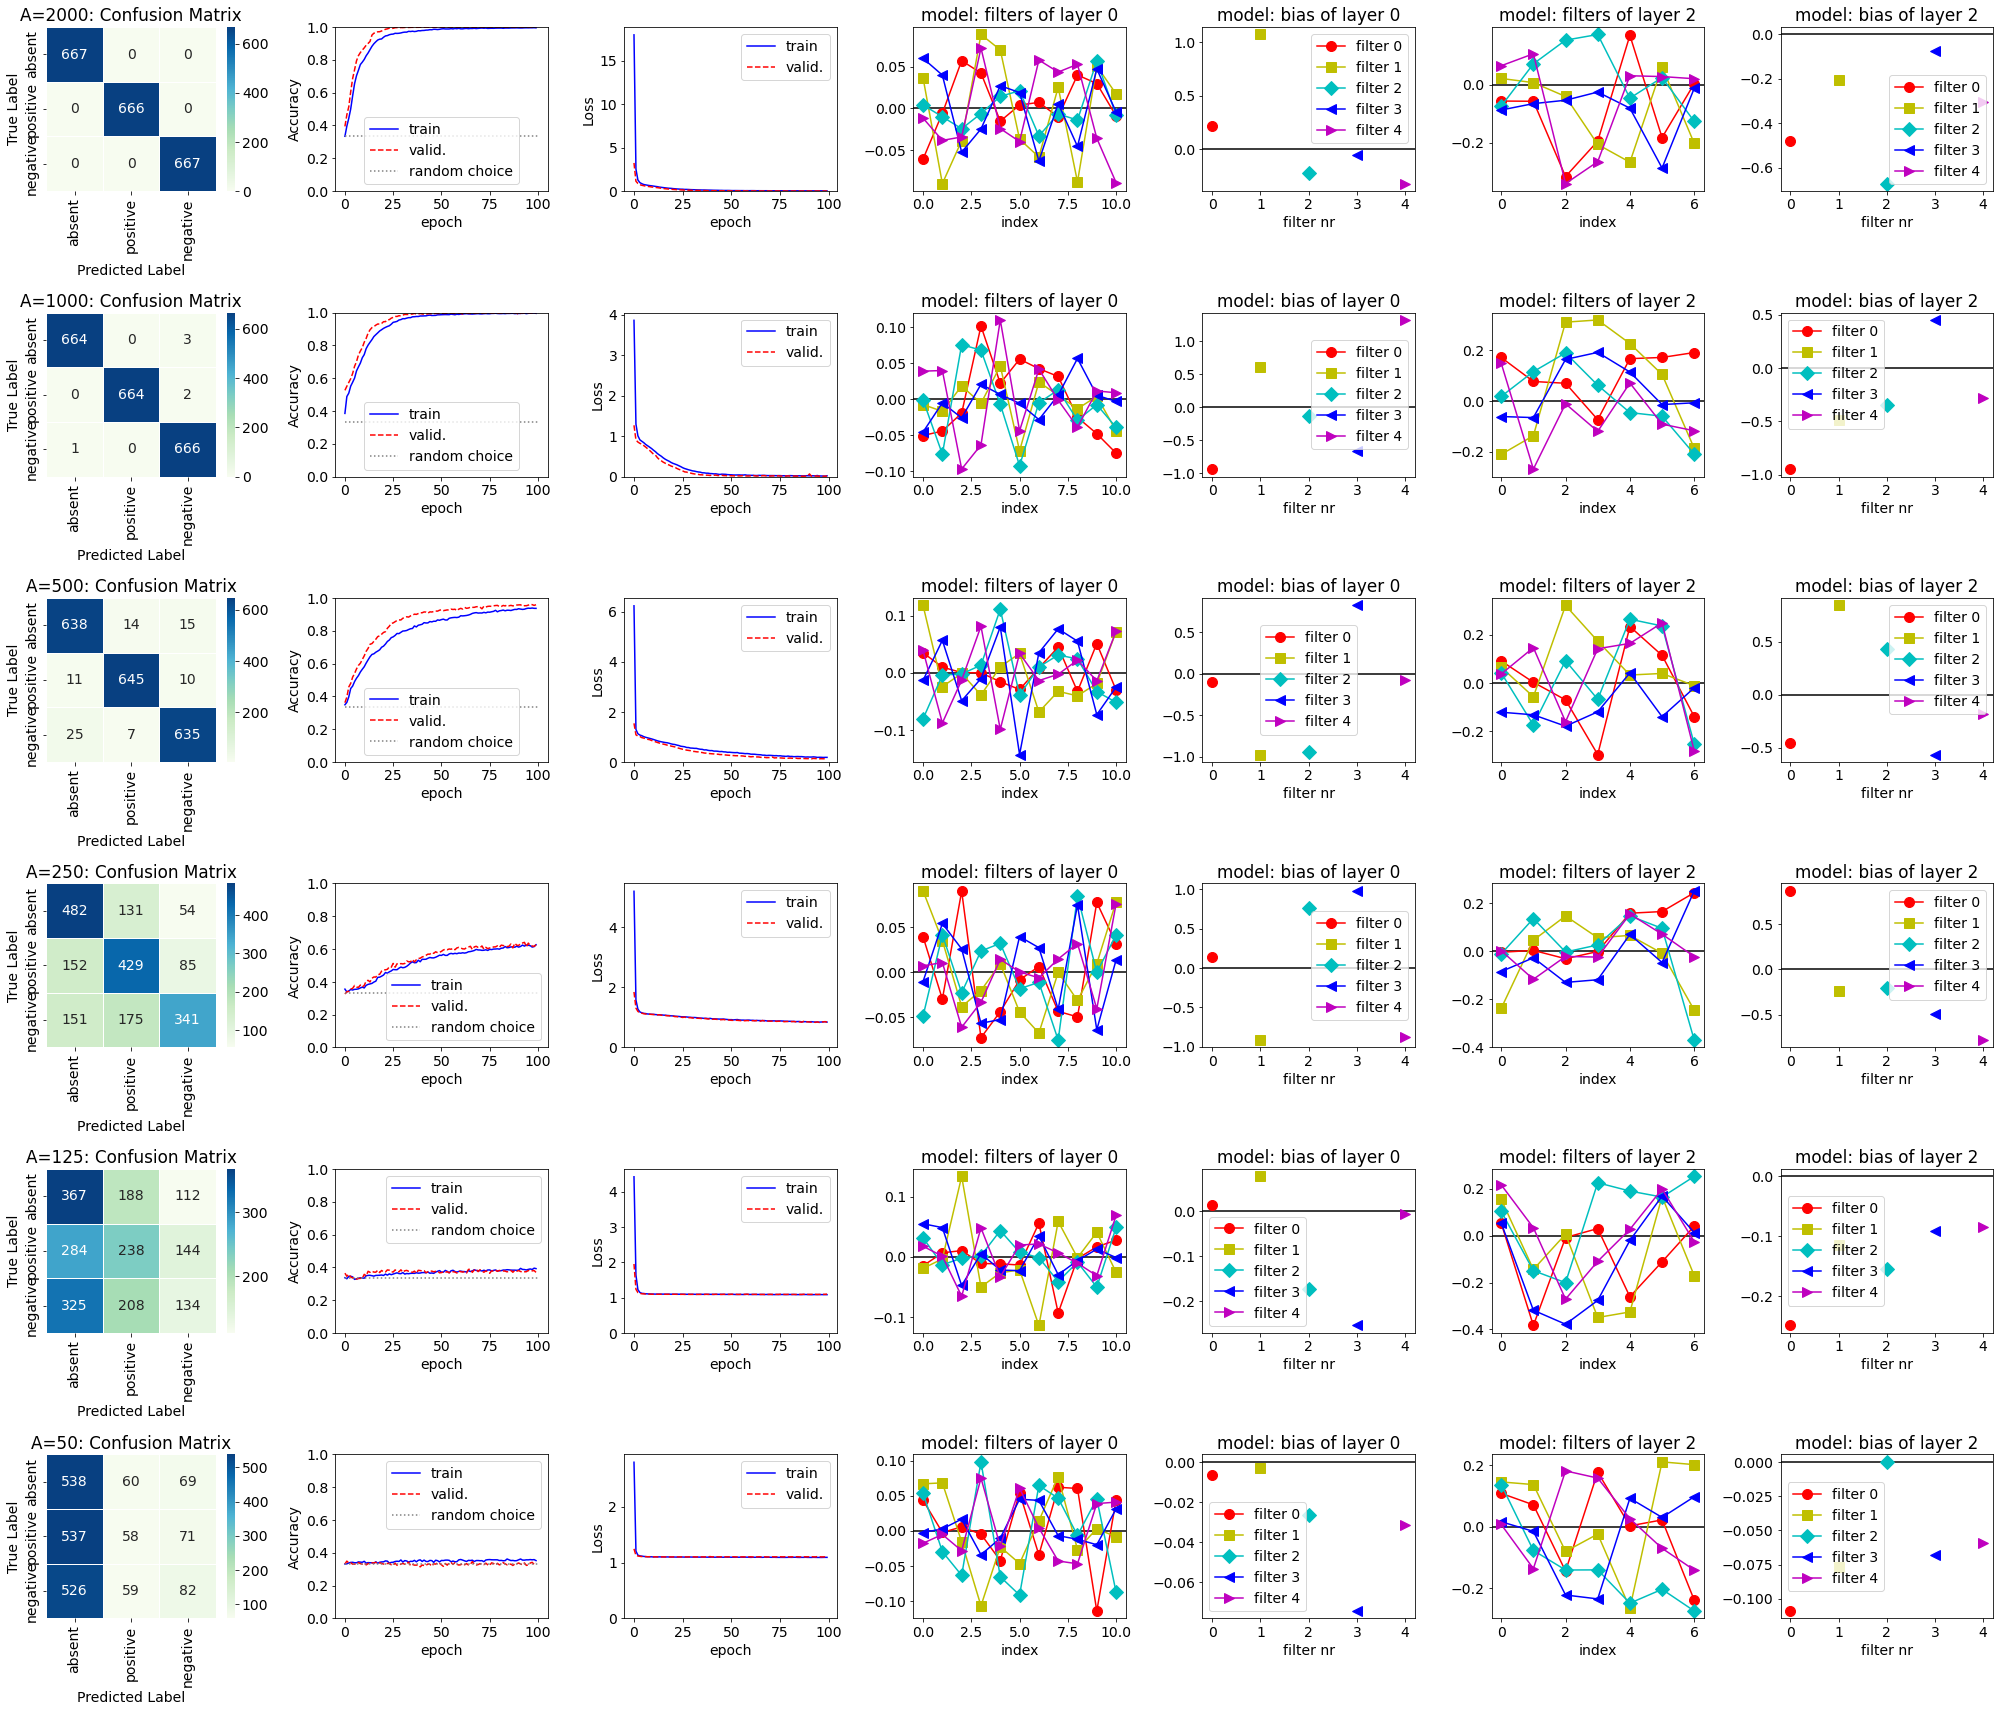

In [32]:
As = [2000,1000,500,250,125,50]
#As = [50,100,250,500,750,1000,1250,1500]
nA = len(As)
fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))
y_pred_val_all =[]
BATCH_SIZE  = 250
EPOCHS  = 100

for A,ax in zip(As,axis):
    str0 = f'ts_L60_Z12_A{A}_DX50_bias5_N10000.dat'
    model = create_model(reg_lambda1=0)
    x_train,y_train,x_val,y_val = load_data(str0)
    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_data=(x_val, y_val), verbose=0, shuffle=True) 
    y_pred_val = model.predict(x_val)
    # Take the class with the highest probability from the val predictions
    max_y_val      = np.argmax(y_val,      axis=1)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)
    y_pred_val_all.append(max_y_pred_val)
    
    show_confusion_matrix(max_y_val, max_y_pred_val,f"A={A}",axis=ax[0])
    Show_history(fit,ax[1],ax[2])
    Show_weights(model,ax[3],ax[4],0)
    Show_weights(model,ax[5],ax[6],2)
    print(f"A :{A}, Final validation accuracy",fit.history["val_accuracy"][-1]," validation loss",fit.history["val_loss"][-1])

plt.tight_layout()
plt.show()


From the above one clearly sees that the accurcay of the model increases with an increasing amplitude. This is because an increased amplitude, gives an increased signal to noise ratio. Hence the original pattern is more easily detectable in the data, and the model is capable of learning much faster. Reducing the original ratio with A = 500 by a factor of 10 yields a dramatic difference where the weights of the model is not able to converge at all.

#### Comparison original vs predictions data's plots

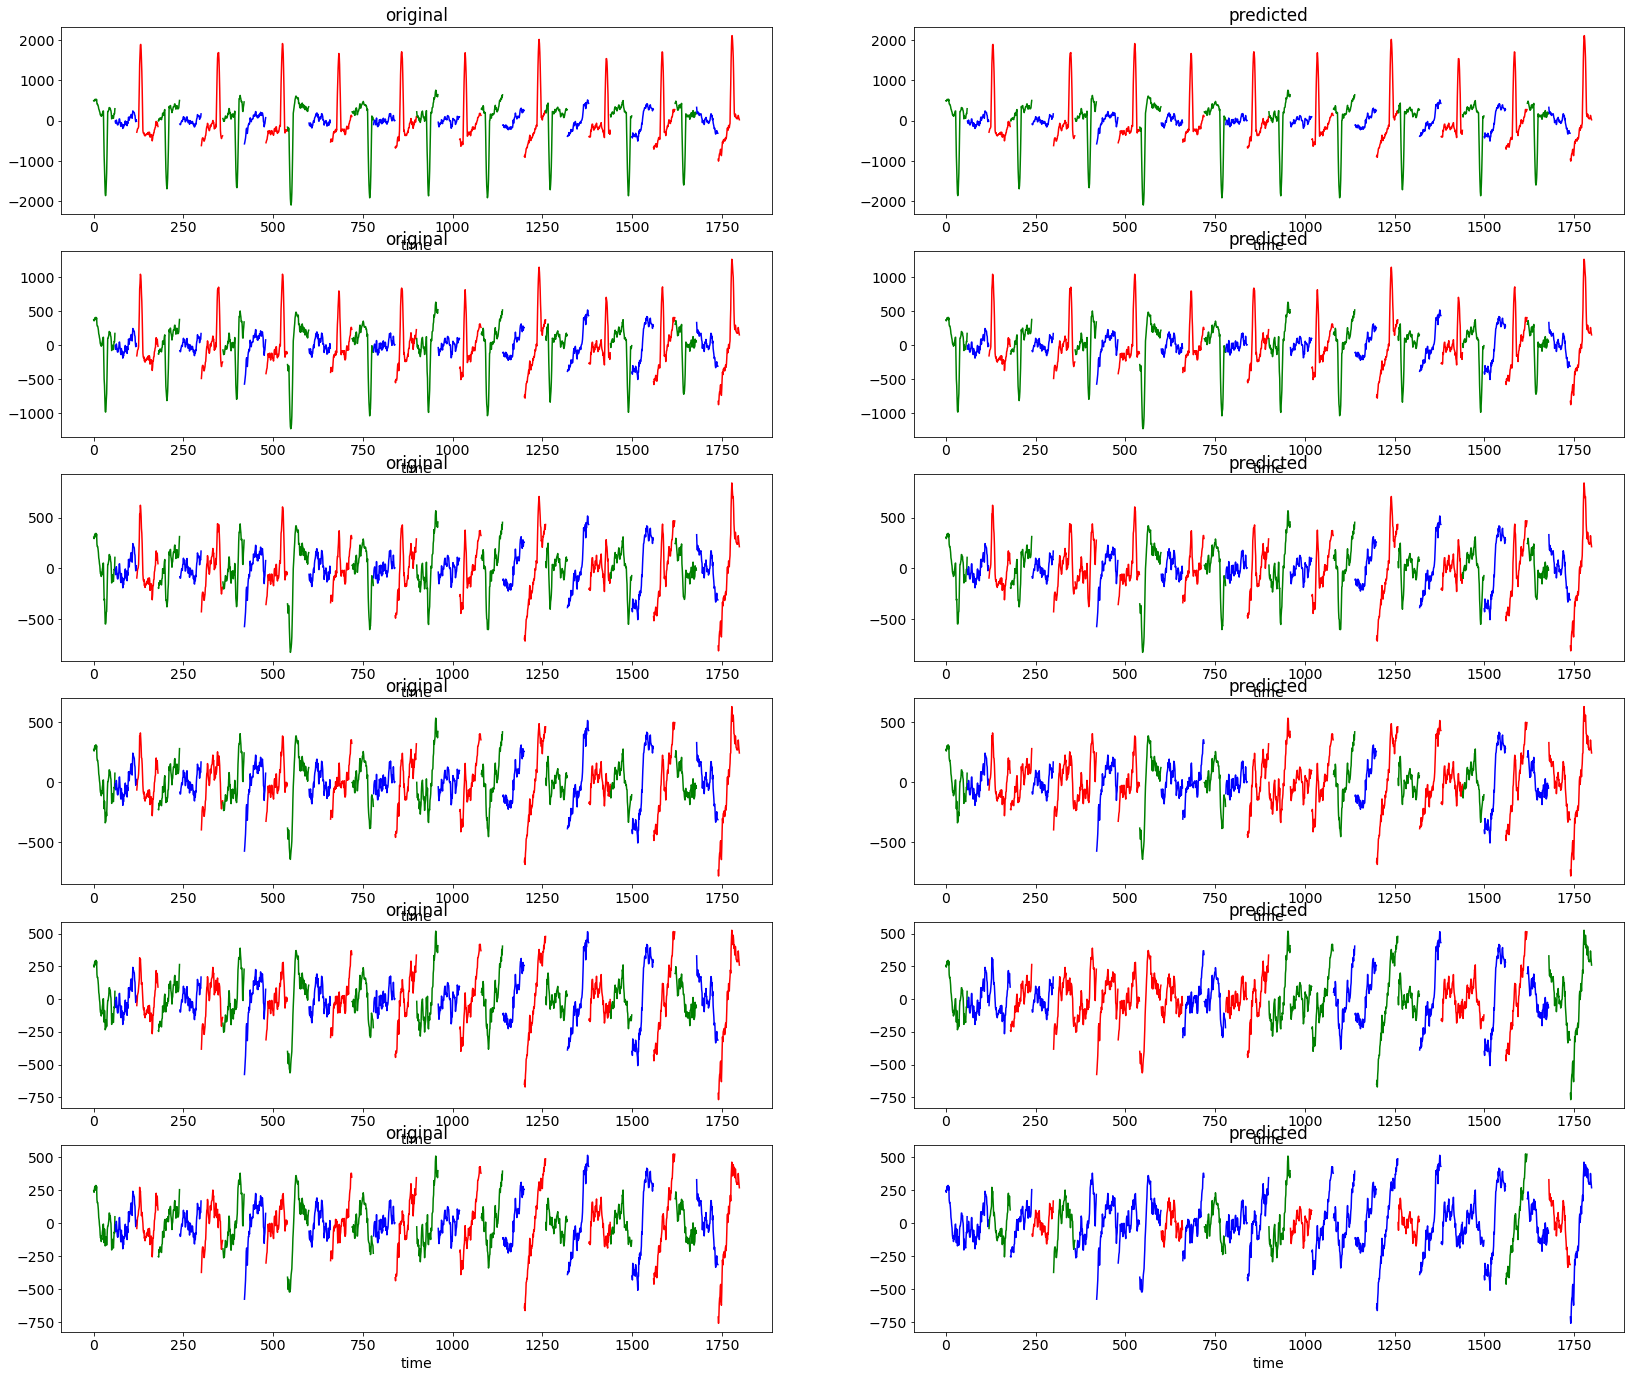

In [44]:
#As = [50,100,250,500,750,1000,1250,1500]
As = [2000,1000,500,250,125,50]
nA = len(As)
fig,axis   = plt.subplots(nA, 2,figsize = (28,4*nA))
BATCH_SIZE = 250
EPOCHS     = 100

for A,y_pred,ax in zip(As,y_pred_val_all, axis):
    str0 = f'ts_L60_Z12_A{A}_DX50_bias5_N10000.dat'
    x_train,y_train,x_val,y_val = load_data(str0)
    max_y_val      = np.argmax(y_val,      axis=1)
    Show_data(x_val, max_y_val,  60,  ax[0], "original")
    Show_data(x_val, y_pred, 60,  ax[1], "predicted")

Pretty evident that with the decreasing of the signal to noise ratio the predictions are less accurate.

## 3 Varying the lambda parameter

### L1 (Lasso)
It is applied a L1 regularization penalty, computed as:   loss = l1 * reduce_sum(abs(x)).
The amplitude is held fixed at A = 500.

lambda :0, Final validation accuracy 0.9585000276565552  validation loss 0.12782011926174164
lambda :1e-05, Final validation accuracy 0.9649999737739563  validation loss 0.1169116273522377
lambda :0.0001, Final validation accuracy 0.9645000100135803  validation loss 0.1185760423541069
lambda :0.001, Final validation accuracy 0.9610000252723694  validation loss 0.13283003866672516
lambda :0.01, Final validation accuracy 0.9704999923706055  validation loss 0.16077037155628204
lambda :0.1, Final validation accuracy 0.9470000267028809  validation loss 0.2959415912628174
lambda :1, Final validation accuracy 0.3330000042915344  validation loss 1.1252020597457886


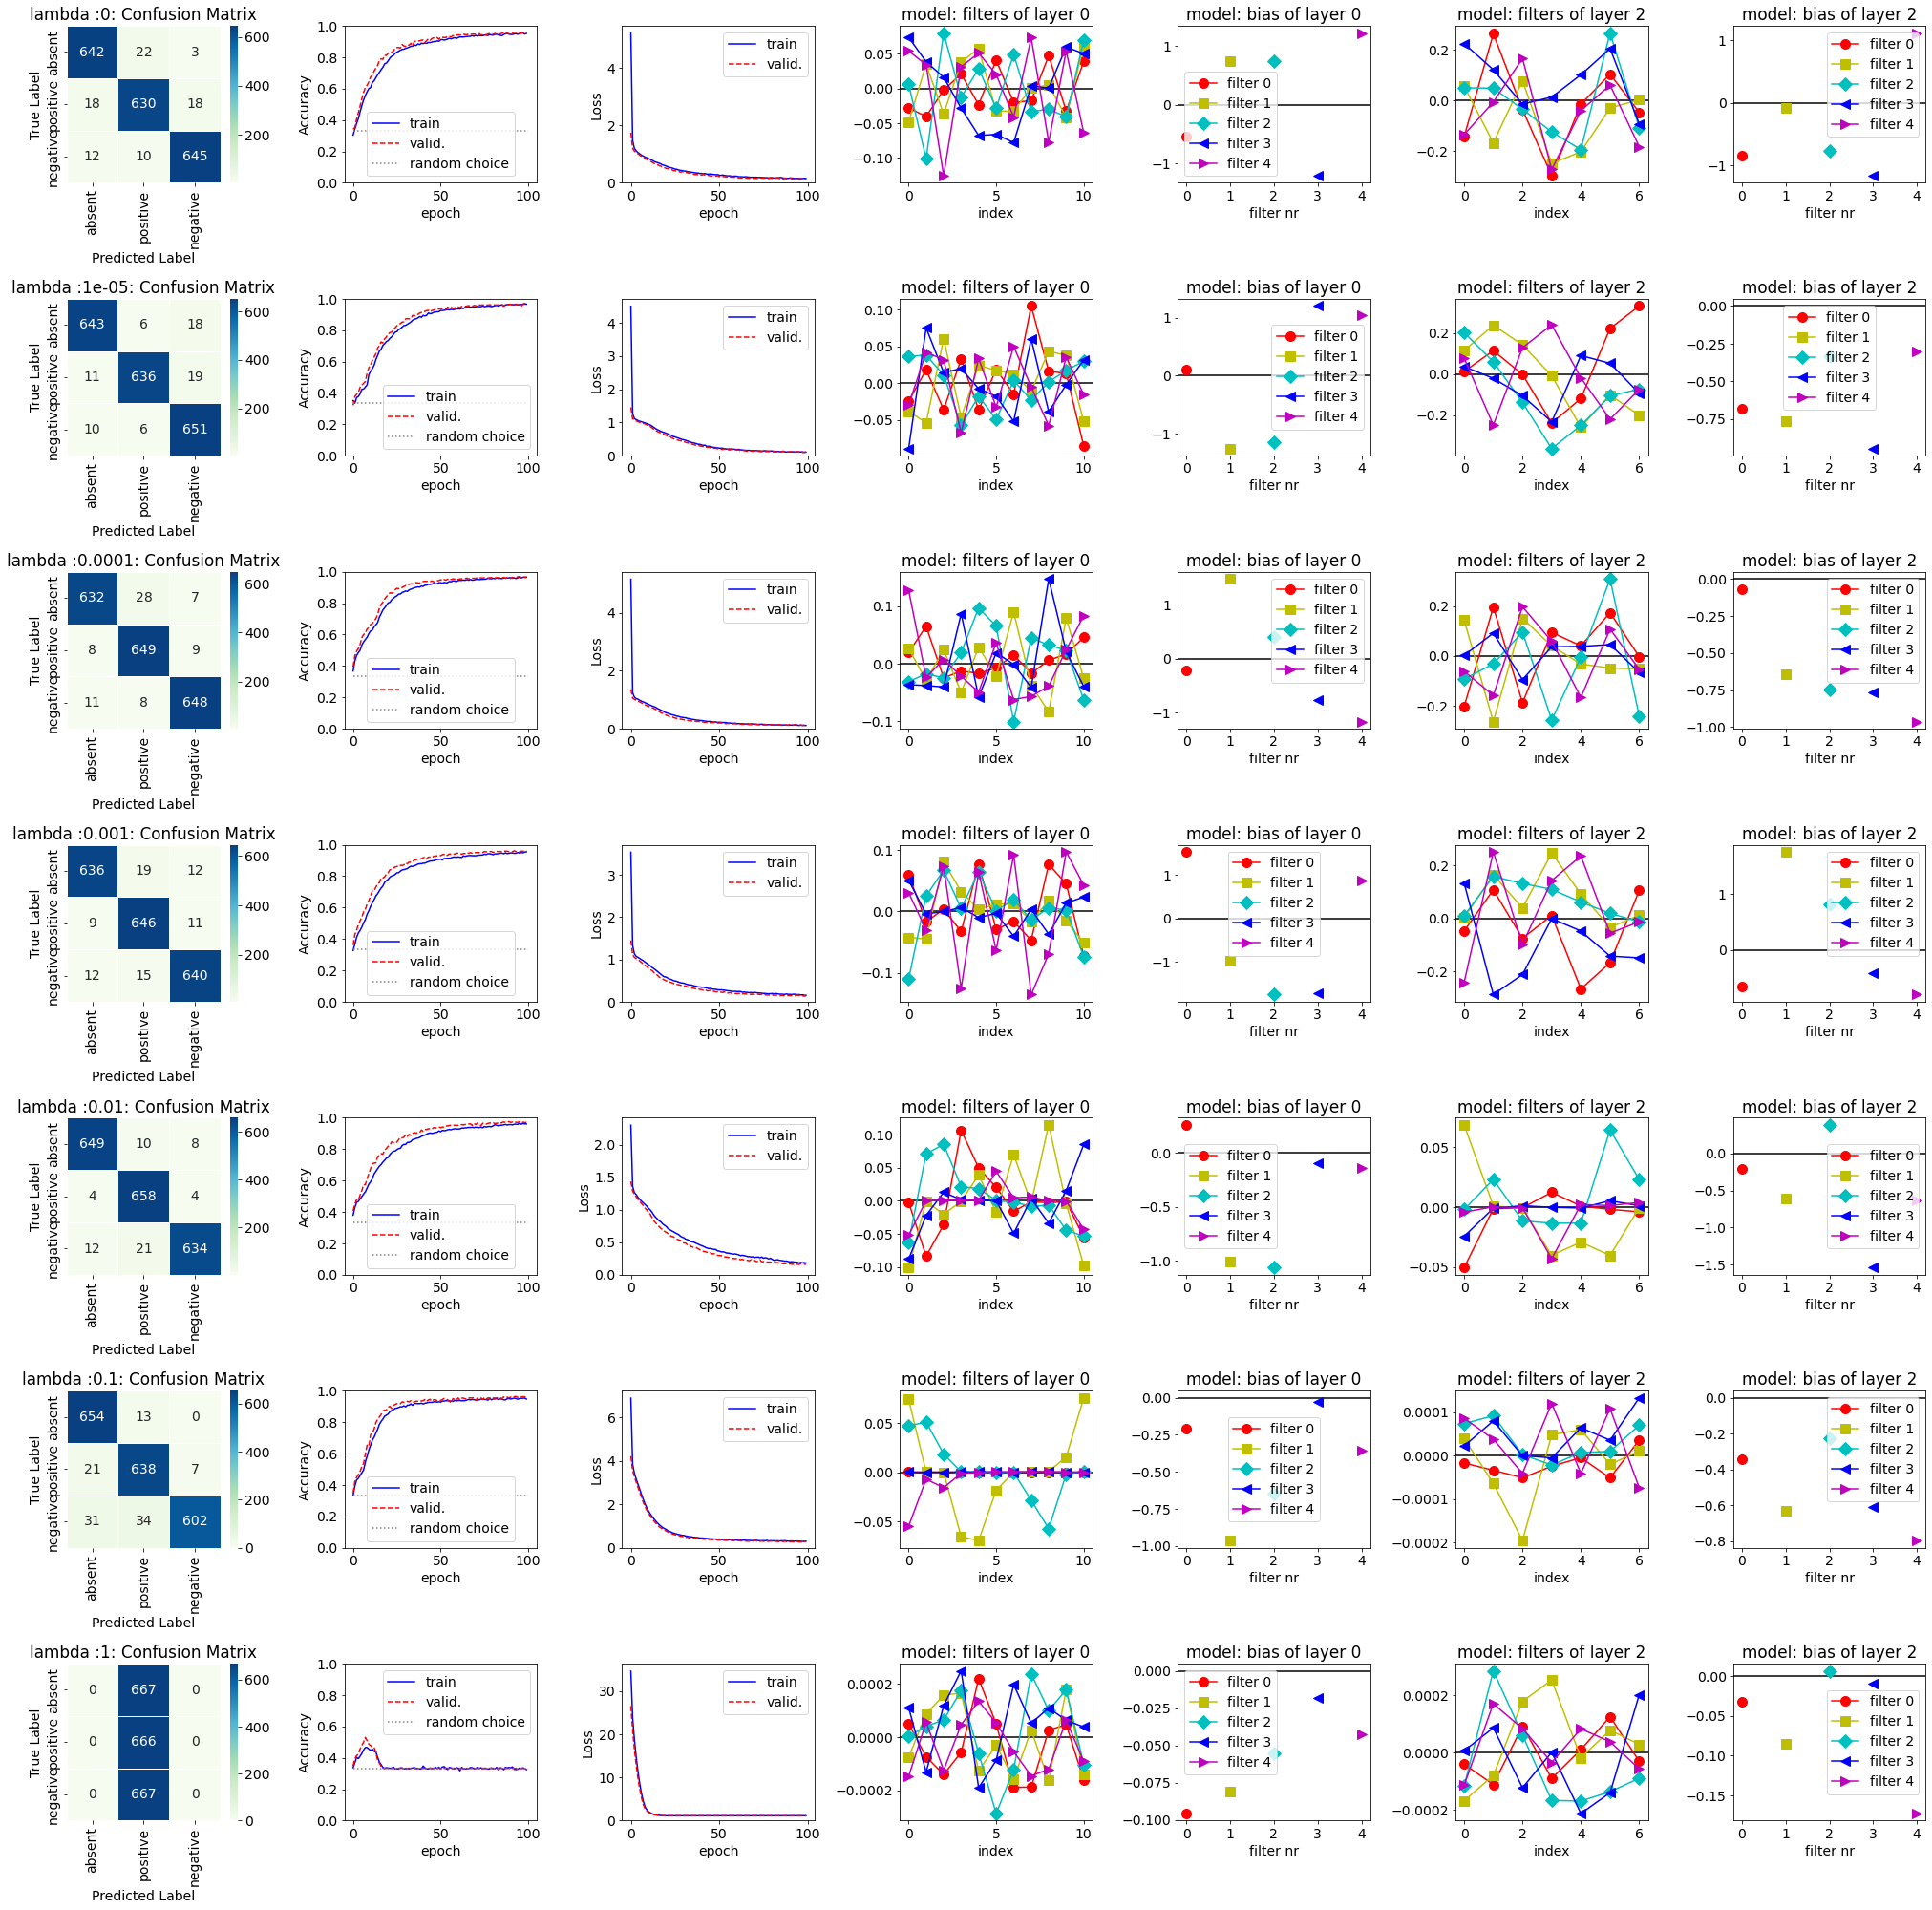

In [40]:
str0 = f'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
x_train,y_train,x_val,y_val = load_data(str0)

reg_lambdas = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1]
nA = len(reg_lambdas)
fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))

for reg_lambda,ax in zip(reg_lambdas,axis):
    model = create_model(reg_lambda1=reg_lambda)

    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_data=(x_val, y_val), verbose=0, shuffle=True) 

    y_pred_val = model.predict(x_val)
    # Take the class with the highest probability from the val predictions
    max_y_val = np.argmax(y_val, axis=1)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)

    label = f"lambda :{reg_lambda}"
    show_confusion_matrix(max_y_val, max_y_pred_val,label,axis=ax[0])
    Show_history(fit,ax[1],ax[2])
    Show_weights(model,ax[3],ax[4],0)
    Show_weights(model,ax[5],ax[6],2)
    print(f"lambda :{reg_lambda}, Final validation accuracy",fit.history["val_accuracy"][-1]," validation loss",fit.history["val_loss"][-1])

plt.tight_layout()
plt.show()

From the plots one can tell that an optimal value of lambda in the case of Lasso regularization is in the interval $\lambda \in\left[0.0001,0.001\right]$, as this yields the best classification and lowest loss. One can also see that with an increasing value of lambda, the value of the weights of the first filters decrease due to the stronger regularization.

### L2 (Ridge)

It is applied a L2 regularization penalty, computed as: loss = l2 * reduce_sum(square(x)). The amplitude is held fixed at A = 500.

lambda :0, Final validation accuracy 0.9505000114440918  validation loss 0.1478465050458908
lambda :1e-05, Final validation accuracy 0.9559999704360962  validation loss 0.1374925971031189
lambda :0.0001, Final validation accuracy 0.9639999866485596  validation loss 0.11658032238483429
lambda :0.001, Final validation accuracy 0.9570000171661377  validation loss 0.13299302756786346
lambda :0.01, Final validation accuracy 0.9610000252723694  validation loss 0.1282503753900528
lambda :0.1, Final validation accuracy 0.9695000052452087  validation loss 0.11469826102256775
lambda :1, Final validation accuracy 0.9539999961853027  validation loss 0.19219614565372467
lambda :10, Final validation accuracy 0.9580000042915344  validation loss 0.2743666172027588


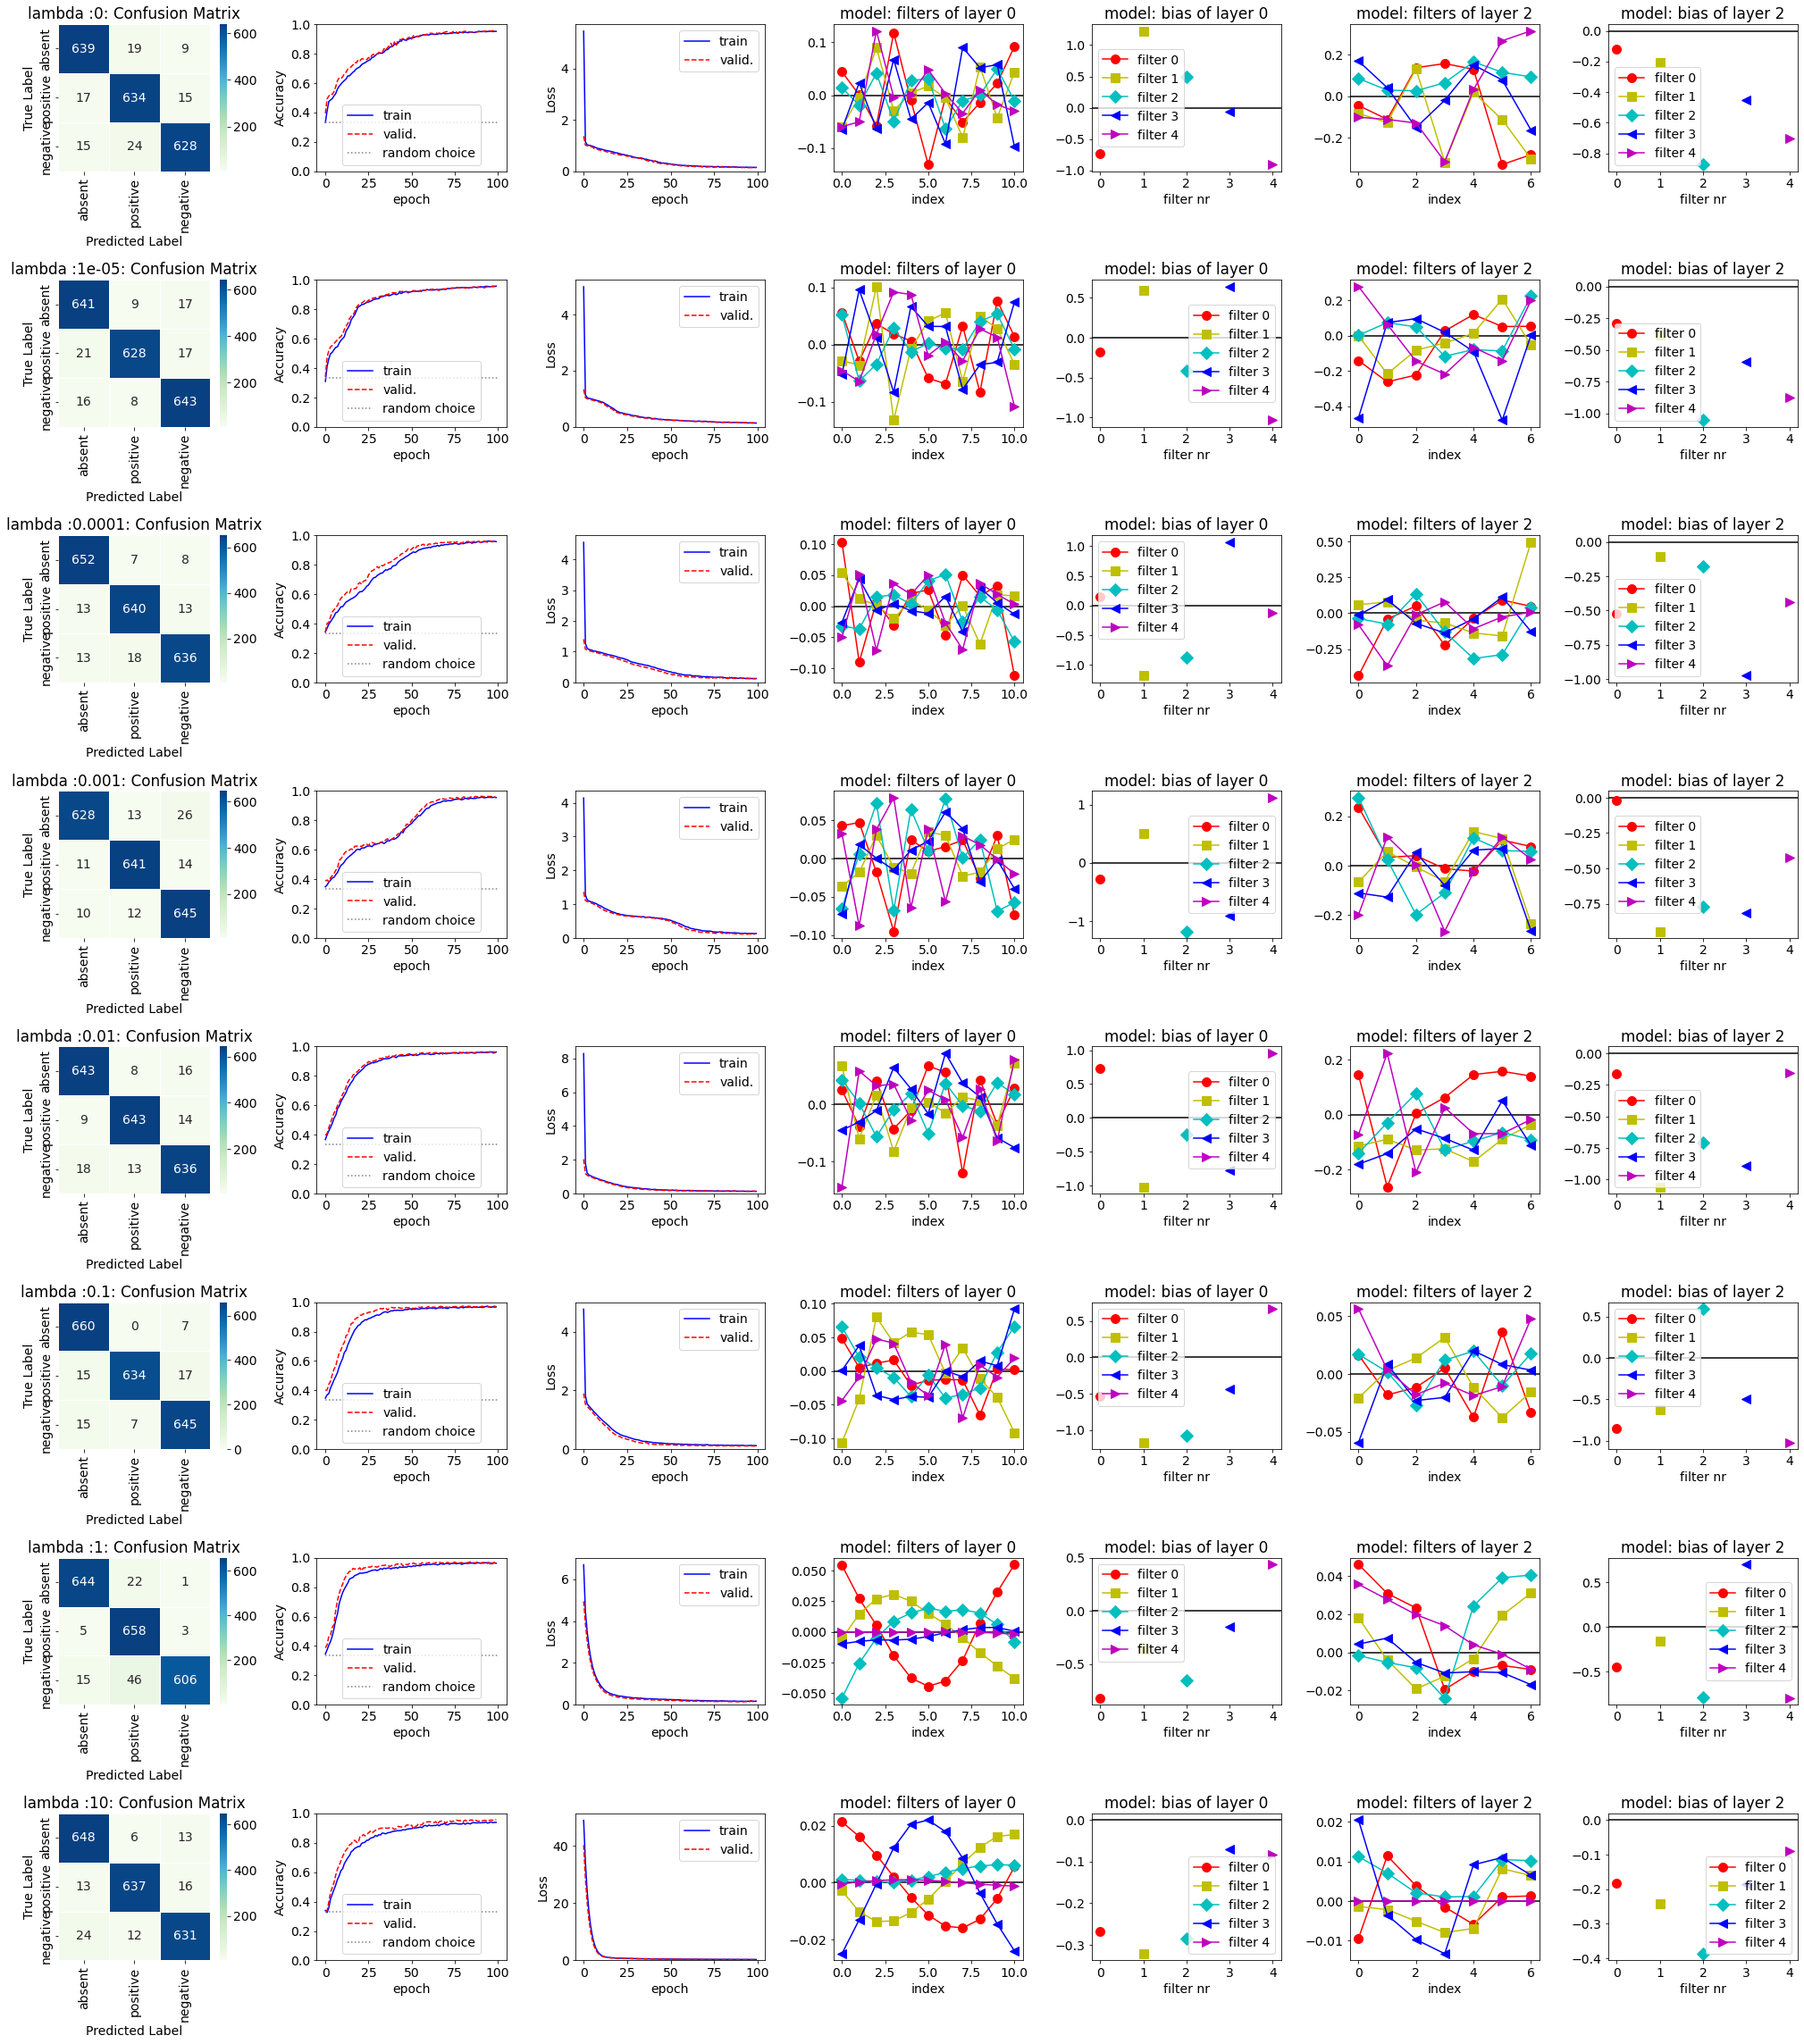

In [41]:
str0 = f'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
x_train,y_train,x_val,y_val = load_data(str0)

reg_lambdas = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
nA = len(reg_lambdas)
fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))

for reg_lambda,ax in zip(reg_lambdas,axis):
    model = create_model(reg_lambda2=reg_lambda,reg_type=2)

    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_data=(x_val, y_val), verbose=0, shuffle=True) 

    y_pred_val = model.predict(x_val)
    # Take the class with the highest probability from the val predictions
    max_y_val = np.argmax(y_val, axis=1)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)

    label = f"lambda :{reg_lambda}"
    show_confusion_matrix(max_y_val, max_y_pred_val,label,axis=ax[0])
    Show_history(fit,ax[1],ax[2])
    Show_weights(model,ax[3],ax[4],0)
    Show_weights(model,ax[5],ax[6],2)
    print(f"lambda :{reg_lambda}, Final validation accuracy",fit.history["val_accuracy"][-1]," validation loss",fit.history["val_loss"][-1])

plt.tight_layout()
plt.show()

The results show that the optimal value of lambda for the L2-regularization is also between 0.0001 and 0.001. We see the same effect of lambda on the weights in the filters, that they decrease with increasing lambda. In the case where lambda is set to 10, the values of the weights are very low, but this also yields the lowest accuracy among the different lambda values.

### Combination of L1 and L2

In [49]:
'''
str0 = f'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
x_train,y_train,x_val,y_val = load_data(str0)

reg_lambdas = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
nA = len(reg_lambdas)


for reg_lambda1,ax in zip(reg_lambdas,axis):
    fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))
    for reg_lambda2 in reg_lambdas:
        model = create_model(reg_lambda1=reg_lambda1, reg_lambda2=reg_lambda2, reg_type=3)

        fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_data=(x_val, y_val), verbose=0, shuffle=True) 

        y_pred_val = model.predict(x_val)
        # Take the class with the highest probability from the val predictions
        max_y_val = np.argmax(y_val, axis=1)
        max_y_pred_val = np.argmax(y_pred_val, axis=1)

        label = f"lambda :{reg_lambda1}"
        show_confusion_matrix(max_y_val, max_y_pred_val,label,axis=ax[0])
        Show_history(fit,ax[1],ax[2])
        Show_weights(model,ax[3],ax[4],0)
        Show_weights(model,ax[5],ax[6],2)
        plt.tight_layout()
        plt.show()
    print(f"lambda1 :{reg_lambda1}, Final validation accuracy",fit.history["val_accuracy"][-1]," validation loss",fit.history["val_loss"][-1])
'''

'\nstr0 = f\'ts_L60_Z12_A500_DX50_bias5_N10000.dat\'\nx_train,y_train,x_val,y_val = load_data(str0)\n\nreg_lambdas = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]\nnA = len(reg_lambdas)\n\n\nfor reg_lambda1,ax in zip(reg_lambdas,axis):\n    fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))\n    for reg_lambda2 in reg_lambdas:\n        model = create_model(reg_lambda1=reg_lambda1, reg_lambda2=reg_lambda2, reg_type=3)\n\n        fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,\n                    validation_data=(x_val, y_val), verbose=0, shuffle=True) \n\n        y_pred_val = model.predict(x_val)\n        # Take the class with the highest probability from the val predictions\n        max_y_val = np.argmax(y_val, axis=1)\n        max_y_pred_val = np.argmax(y_pred_val, axis=1)\n\n        label = f"lambda :{reg_lambda1}"\n        show_confusion_matrix(max_y_val, max_y_pred_val,label,axis=ax[0])\n        Show_history(fit,ax[1],ax[2])\n        Show_weights(model,ax[3],ax[4],0)\n    

The combination of L1 and L2 regularization also performs best with a lambda between 0.0001 and 0.001.

In [ ]:
## We have 64 combinations of the 2 parameter: shall we implement a grid search instead?
reg_lambdas1 = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
reg_lambdas2 = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]

param_grid = dict(
    reg_lambda1 = reg_lambdas1,
    reg_lambda2 = reg_lambdas2
    )

str0 = f'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
x_train,y_train,x_val,y_val = load_data(str0)

model_architecture_search = KerasClassifier(
    build_fn = create_model,
    verbose = 0
    )

grid_architecture = GridSearchCV(
    model_architecture_search,
    param_grid = param_grid,
    cv = 10
    )

grid_architecture_result = grid_architecture.fit(
    x_train,y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data=(x_val,y_val),
    )

print_grid_search_results(grid_architecture_result,20)

## 4. Comparison between different architectures

Using the best model made last year.

In [57]:
def create_best_model(reg_type=3,reg_lambda=0.0001):
    if reg_type == 1:
        reg = tf.keras.regularizers.l1(reg_lambda)
    
    elif reg_type == 2:
        reg = tf.keras.regularizers.l2(reg_lambda) ## raised to 0.2
        
    elif reg_type == 3:
        reg = tf.keras.regularizers.l1_l2(reg_lambda, reg_lambda)
        

    #ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                           # seed=None)
    ini = tf.keras.initializers.GlorotNormal()
    
    model = Sequential()
    model.add(Conv1D(filters=6, kernel_size=3, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    model.add(Conv1D(filters=8, kernel_size=9, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    model.add(Conv1D(filters=4, kernel_size=3, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    model.add(GlobalMaxPooling1D( ))
    model.add(Flatten())
    model.add(Dense(3, activation='relu'))

    opt = tf.keras.optimizers.Adam()

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=opt,metrics=['accuracy'])
    
    return model

In [58]:
model_best = create_best_model(reg_lambda = 0)
model_best.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_136 (Conv1D)         (None, 58, 6)             24        
                                                                 
 conv1d_137 (Conv1D)         (None, 50, 8)             440       
                                                                 
 conv1d_138 (Conv1D)         (None, 48, 4)             100       
                                                                 
 global_max_pooling1d (Globa  (None, 4)                0         
 lMaxPooling1D)                                                  
                                                                 
 flatten_68 (Flatten)        (None, 4)                 0         
                                                                 
 dense_136 (Dense)           (None, 3)                 15        
                                                     

Epoch 1/100
32/32 - 2s - loss: 6.2813 - accuracy: 0.3837 - val_loss: 5.8350 - val_accuracy: 0.3835 - 2s/epoch - 48ms/step
Epoch 2/100
32/32 - 1s - loss: 5.8233 - accuracy: 0.3999 - val_loss: 5.8228 - val_accuracy: 0.3905 - 562ms/epoch - 18ms/step


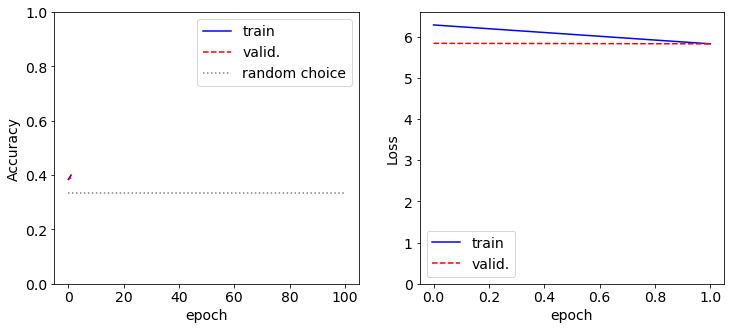

In [64]:
#Lets redo the run with varying amplitude
#As = [50,100,250,500,750,1000,1250,1500]
#As = [500]
#nA = len(As)
#fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))
BATCH_SIZE = 250
EPOCHS = 100

streng = 'ts_L60_Z12_A250_DX50_bias5_N10000.dat'

model_best = create_best_model(reg_lambda = 0)
x_train,y_train,x_val,y_val = load_data(streng)
es = EarlyStopping(monitor='val_loss', mode='min')
fit_best = model_best.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_data=(x_val, y_val), verbose=2, shuffle=True, callbacks = [es]) 
y_pred_val = model_best.predict(x_val)
    # Take the class with the highest probability from the val predictions
max_y_val      = np.argmax(y_val,      axis=1)
max_y_pred_val = np.argmax(y_pred_val, axis=1)

#show_confusion_matrix(max_y_val, max_y_pred_val,f"A={A}",axis=ax[0])
Show_history_single(fit_best)
#Show_weights(model,ax[3],ax[4],0)
#Show_weights(model,ax[5],ax[6],2)
#print(f"A :{A}, Final validation accuracy",fit.history["val_accuracy"][-1]," validation loss",fit.history["val_loss"][-1])
